In [8]:
# common packages 
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axis3d # missing in tutorial
from mpl_toolkits.mplot3d import art3d # missing in tutorial
from functools import reduce
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

# reading in dicom files
import pydicom

# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops

# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage

# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *

#inspect objects
import inspect


# save function
# import chart_studio.plotly as py
# set plotly credentials here 
# this allows you to send results to your account plotly.tools.set_credentials_file(username=your_username, api_key=your_key)

In [9]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] -   
                          slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - 
                      slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(scans):
    #get image
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    print(np.min(image))
    print(np.max(image))
    
    #image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    
    #intercept = scans[0].RescaleIntercept
    #slope = scans[0].RescaleSlope
    
    #if slope != 1:
    #    image = slope * image.astype(np.float64)
    #   image = image.astype(np.int16)
        
    #image += np.int16(intercept)
    
    
    return np.array(image, dtype=np.int16)

In [10]:
#slow control
def CenterOfMassRecursion(arr):
    """calculate Center of mass of numpy array recursively using array coordinates. """
    #print("Center of mass(\n", arr)
    position = np.array(arr.shape)
    position *= 0
    counts = 0
    #print(pos)
    for x in range(arr.shape[0]):
        if len(arr.shape)==1:
            position += arr[x]*x
            counts +=arr[x]
        else:
            pos,cnt = CenterOfMassRecursion(arr[x])
            position[0] += x*cnt
            position[1:] +=pos
            counts += cnt
            
    return position, counts

In [11]:
#a faster way
def CenterOfMassMultiplication(arr):
    """calculate Center of mass of numpy array with array multiplication using array coordinates. """
    #calculate 1-D representations of grid
     
    arr64 = np.array(arr, dtype=np.int64)
    counts = np.sum(arr64)
    coordinates = np.zeros(shape=(len(arr64.shape),), dtype=np.int64)
    for k in range(0,len(arr64.shape)): 
        temp = np.arange(0,arr64.shape[k],1)
        temp_shape = np.ones(len(arr64.shape), dtype=np.int64)
        temp_shape[k] = len(temp)
        temp_shape = tuple(temp_shape)
        temp = np.reshape(temp, tuple(temp_shape))
        temp = arr64*temp
        temp = np.sum(temp)
        coordinates[k]=temp
    return coordinates, counts

In [12]:
#coordinate system of images,
#according to interpretation of Siemens coordinates and KEX phantom motion
img_dim_titles = ["z [axial to bedfoot]", "y [down]", "x [right]"]

In [13]:
print(inspect.getmembers(patient_pixels))

[('T', array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0

In [14]:
#phantom options and folders
folder_appendix = "PET-Converted"
phantom_strings = ["Cylinder", "Kanyl"]
desk_path = r"C:\Users\petct\Desktop"

#get relevant subdirectories
sub_dirs = []
#folders of sinogram gates 00, 01
folders = [0,1]
for phant in phantom_strings:
    top = os.path.join(desk_path, phant+folder_appendix)
    for (root, dirs, files) in os.walk(top, topdown=True):

        sub_dirs.append([dirs[d] for d in folders])
        break

In [15]:
#choose phantom and reconstruction method 

phantom_widget=widgets.Dropdown(
    options=phantom_strings,
    value=phantom_strings[0],
    description='phantom:',
    disabled=False,
)
        
recon_widget = widgets.Dropdown(
    options=[],
    description='Rec. method:',
    disabled=True,
)


def update_recon_options(phantom_widget, recon_widget):
    #get options from gate
    recon_options = []
    trimmed_options = []
    subdir = sub_dirs[phantom_strings.index(phantom_widget.value)][0]
    top = os.path.join(
        desk_path, 
        phantom_widget.value+folder_appendix, 
        subdir,
    )
    for (root, dirs, files) in os.walk(top,topdown=True):
        recon_options = dirs
        break
    #extract distinguishing part of reconstruction names
    trimmed_options = []
    for r in recon_options:
        temp = r[len(subdir)+1:]
        splitup = temp.split('_')
        trimmed_options.append(splitup[0])
    recon_widget.disabled = False
    recon_widget.options = trimmed_options
    recon_widget.recon_options = recon_options

update_recon_options()
phantom_widget.observe(update_recon_options, 'value')

#user input
def f(x,y):
    return;
interact(f,x=phantom_widget, y=recon_widget);

interactive(children=(Dropdown(description='phantom:', options=('Cylinder', 'Kanyl'), value='Cylinder'), Dropd…

In [16]:
#get phantom reconstructions
#get index
phantom_index = phantom_strings.index(phantom_widget.value)
recon_index = recon_widget.options.index(recon_widget.value)
#get full recon folder name
chosen_recon = recon_widget.untrimmedOptions[recon_index]
#print("full folder name:", chosen_recon)
recons = []
for frame in sub_dirs[phantom_index]:
    frame_recon = frame + chosen_recon[len(frame):]
    path = os.path.join(
    desk_path,
    phantom_strings[phantom_index]+folder_appendix,
    frame,
    frame_recon)
    #print(path)
    patient_dicom = load_scan(path)
    patient_pixels = get_pixels_hu(patient_dicom)
    recons.append(patient_pixels)
    
#Calculate CenterOfMass
for r in recons:
    position, counts = CenterOfMassMultiplication(np.copy(r))
    print("shape", r.shape)
    print("Center of mass at pixels ", np.flip(position//counts))

#plot selection

dim_widget = IntSlider(min=0, max=2, step=1, value=0, continuous_update=False)
slice_widget = IntSlider(min=0, max=50, step=1, value=50, continuous_update=False)

def update_slice_range(*args):
    #dim = dim_widget.value
    slice_widget.max = patient_pixels.shape[dim_widget.value]-1
    
dim_widget.observe(update_slice_range, 'value')
update_slice_range()


def dicom_animation(dim,x):
    size = recons[0].shape
    dim_order = [dim]
    for i in range(0,len(img_dim_titles)):
        if i != dim:
            dim_order.append(i) 
    columns = len(recons)
    scale=10
    plt.figure(figsize=(scale*columns,scale))
    phantom_str = phantom_strings[phantom_index]
    plt.suptitle( recon_widget.value + " recon. " + phantom_str, fontsize=30)
    
    for k in range(0,columns):   
        plt.subplot(1,columns,k+1)
        temp = recons[k].transpose(tuple(dim_order))
        
        position, counts = CenterOfMassMultiplication(np.array(temp))
        print("position", position)
        print("counts", counts)
        
        if counts > 0:
            position = position//counts
        

        img = plt.imshow(temp[x])
        frame = sub_dirs[phantom_index][k]
        frame_id = frame[len(phantom_str)+4:]
        plt.title("gate " + frame_id + 
            "\nslice at " + img_dim_titles[dim] + "=" + str(x) +
            "\nimage mean at pixels [z y x]=" + str(position)
        )
        # imshow shows images (x,y) with x down and y right, cartesian with x down
        plt.xlabel(img_dim_titles[dim_order[2]])
        plt.ylabel(img_dim_titles[dim_order[1]])
    return

interact(dicom_animation, dim=dim_widget, x=slice_widget);
#plt.set_cmap('gray')dim_w
#colorbar

plt.show();



0
32767
0
32767
shape (109, 200, 200)
Center of mass at pixels  [ 99 120  47]
shape (109, 200, 200)
Center of mass at pixels  [ 99 137  47]


interactive(children=(IntSlider(value=0, continuous_update=False, description='dim', max=2), IntSlider(value=5…

0
32767


Text(0.5, 1.0, 'reconstruction of copy')

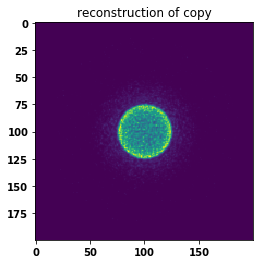

In [7]:
#Cylinder
# set path and load files 

path = r"C:\Users\petct\Desktop\Hugo\Code\VG60TestData-Converted\VG60TestData-WB\VG60TestData-WB-OPTOF_000_000.v-DICOM"
#path = r"C:\Users\petct\Desktop\KEX-recons\Cylinder_2sek_OP"
#path = r"C:\Users\petct\Desktop\KEX-recons\Cylinder_2smeddatafrånverbose!!_OP"
#path = r"C:\Users\petct\Desktop\KEX-recons\Cylinder_61sek_OP"
#path = r"C:\Users\petct\Desktop\KEX-recons\Kanyl_2sek_OP"
#path = r"C:\Users\petct\Desktop\KEX-recons\Kanyl_61sek_op"
#path = r"C:\Users\petct\Desktop\KEX-LM\PET_BRAIN_TOF_HD_0005-20190215T135737Z-001\PET_BRAIN_TOF_HD_0005"
#path = r"C:\Users\petct\Desktop\KanylPET-Converted\KanylPET-WB\KanylPET-WB-umap_000_000.v-DICOM"
#path = r"C:\Users\petct\Desktop\KanylPET-Converted\KanylPET-WB\KanylPET-WB-umapBedRemoval_000_000.v-DICOM"
#path = r"C:\Users\petct\Desktop\NyKingston\KEX_12345678\PET_H_FDG_(ADULT)_20190125_150451_838000-Converted\PET_H_FDG_(ADULT)_20190125_150451_838000-WB\PET_H_FDG_(ADULT)_20190125_150451_838000-WB-umap_000_000.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-aw_00_00.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-aw-Assembled.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-fbp_00_00.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-fbp-Assembled.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-op_00_00.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-op-Assembled.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-psf_00_00.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-psf-Assembled.v-DICOM"
#path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-umap_00.v-DICOM"
path = r"C:\Users\petct\Desktop\CylinderPET-Converted\CylinderPET-LM-00\CylinderPET-LM-00-OPTOF_000_000.v-DICOM"

#sanity check
slice = 40;
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
plt.figure(figsize=(10,10))
plt.imshow(patient_pixels[slice]);
plt.title("reconstruction of copy")
    #original_dcm_pix = 81;
    



In [270]:
# slide through dicom images using a slide bar 


def dicom_animation(z):
    #figure
    img = plt.imshow(patient_pixels[z])
    return z

interact(dicom_animation, z=(0, patient_pixels.shape[0]-1));
#plt.set_cmap('gray')
#colorbar

plt.show();



interactive(children=(IntSlider(value=54, description='z', max=108), Output()), _dom_classes=('widget-interact…

In [431]:
# slide through dicom images using a slide bar 
# path = r"C:\Users\petct\Desktop\Siemense7tools\Siemense7tools\JSRecon12-TestData\mCTTestData-Converted\mCTTestData-WB\mCTTestData-WB-op_00_00.v-DICOM"
#path = r"C:\Users\petct\Desktop\Hugo\Code\VG60TestData-Converted\VG60TestData-WB\VG60TestData-WB-OPTOF_000_000.v-DICOM"
path = r"C:\Users\petct\Desktop\CylinderPET-Converted\CylinderPET-01\CylinderPET-01-OPTOF_000_000.v-DICOM"
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)
dim=0
size = patient_pixels.shape
dim_order = [dim]
for i in range(0,len(img_dim_titles)):
    if i != dim:
        dim_order.append(i) 
# print(dim_order)


dim_widget = IntSlider(min=0, max=2, step=1, value=0)
slice_widget = IntSlider(min=0, max=50, step=1, value=50)

def update_slice_range(*args):
    #dim = dim_widget.value
    slice_widget.max = patient_pixels.shape[dim_widget.value]-1
    
dim_widget.observe(update_slice_range, 'value')
update_slice_range()

def dicom_animation(dim_zyx,x):
    #figure
    size = patient_pixels.shape
    dim_order = [dim_zyx]
    for i in range(0,len(img_dim_titles)):
        if i != dim_zyx:
            dim_order.append(i) 
    
    temp = patient_pixels.transpose(tuple(dim_order))
    img = plt.imshow(temp[x])
    plt.title(" slice at " + img_dim_titles[dim_zyx] + "=" + str(x) )
    # imshow shows images (x,y) with x down and y right, cartesian with x down
    plt.xlabel(img_dim_titles[dim_order[2]])
    plt.ylabel(img_dim_titles[dim_order[1]])
    return

interact(dicom_animation, dim_zyx=dim_widget, x=slice_widget);
#plt.set_cmap('gray')dim_w
#colorbar

plt.show();

interactive(children=(IntSlider(value=0, description='dim_zyx', max=2), IntSlider(value=50, description='x', m…

In [430]:
arr = np.array([[1,2,3],[4,5,6]])
position, counts = CenterOfMassRecursion(arr)

print("point sum", position)
print("counts", counts)
print("normalized position", position / counts)

point sum [15 25]
counts 21
normalized position [0.71428571 1.19047619]


In [432]:
#position,count = CenterOfMass(patient_pixels[0:10])
#print(position, count)
#print(position/count)

#position,count = CenterOfMass(patient_pixels[100:110])
#print(position, count)
#print(position/count)

path = r"C:\Users\petct\Desktop\CylinderPET-Converted\CylinderPET-01\CylinderPET-01-OPTOF_000_000.v-DICOM"
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)

x = []
y = []
hori = []
slice_counts = []

for z in range(0,patient_pixels.shape[0]):
    hori.append(z)
    position,counts = CenterOfMassRecursion(patient_pixels[z])
    x.append(position[1]/counts)
    y.append(position[0]/counts)
    slice_counts.append(counts)


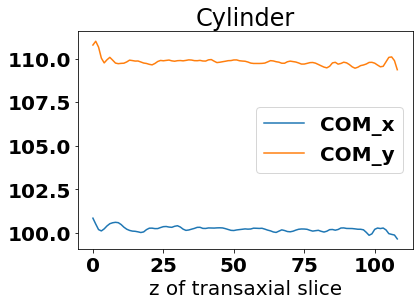

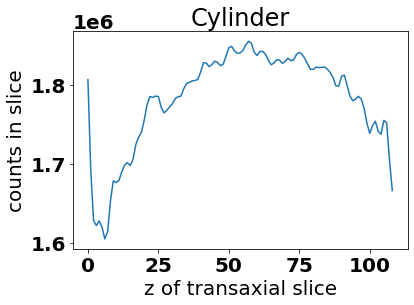

In [433]:

plt.plot(hori,x,hori,y)
plt.xlabel("z of transaxial slice")
plt.legend(["COM_x", "COM_y"])
plt.title("Cylinder")
plt.show()

plt.plot(hori, slice_counts)
plt.xlabel("z of transaxial slice")
plt.ylabel("counts in slice")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 
plt.title("Cylinder")
plt.show()
    

In [299]:
x_widget = FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value
    
y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)

interact(printer,x=x_widget, y=y_widget);

interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, step=0.05), FloatSlider(value=5.0, des…

In [190]:
# slide through dicom images using a slide bar 

def dicom_animation(y):
    #figure
    img = plt.imshow(patient_pixels[:,:,y])
    return y

interact(dicom_animation, y=(0, patient_pixels.shape[2]-1));
#plt.set_cmap('gray')
#colorbar

plt.show();

interactive(children=(IntSlider(value=99, description='y', max=199), Output()), _dom_classes=('widget-interact…

In [149]:
#all different reconstructions

top = r"C:\Users\petct\Desktop\CylinderPET-Converted"

for root, dirs, files in os.walk(top):
    #print(root)
    subs = dirs
    #print(dirs)
    break
    for name in dirs:
        print (os.path.join(root, name))

#print(subs)
subs = [subs[0],subs[1], subs[4]]
#print(subs)
#print("----------")
img_titles = []
for k in subs:
    #print(k)
    for root, dirs, files in os.walk(os.path.join(top,k)):
        img_titles.append(dirs)
        #print(len(dirs))
        #print(dirs)
        break

#print("----")
#print(img_titles)
#print("images titles shape:", len(img_titles), len(img_titles[0]))
#print(np.array(img_titles).size)

1
4
7
10
13
16
2
5
8
11
14
17
3
6
9
12
15
18


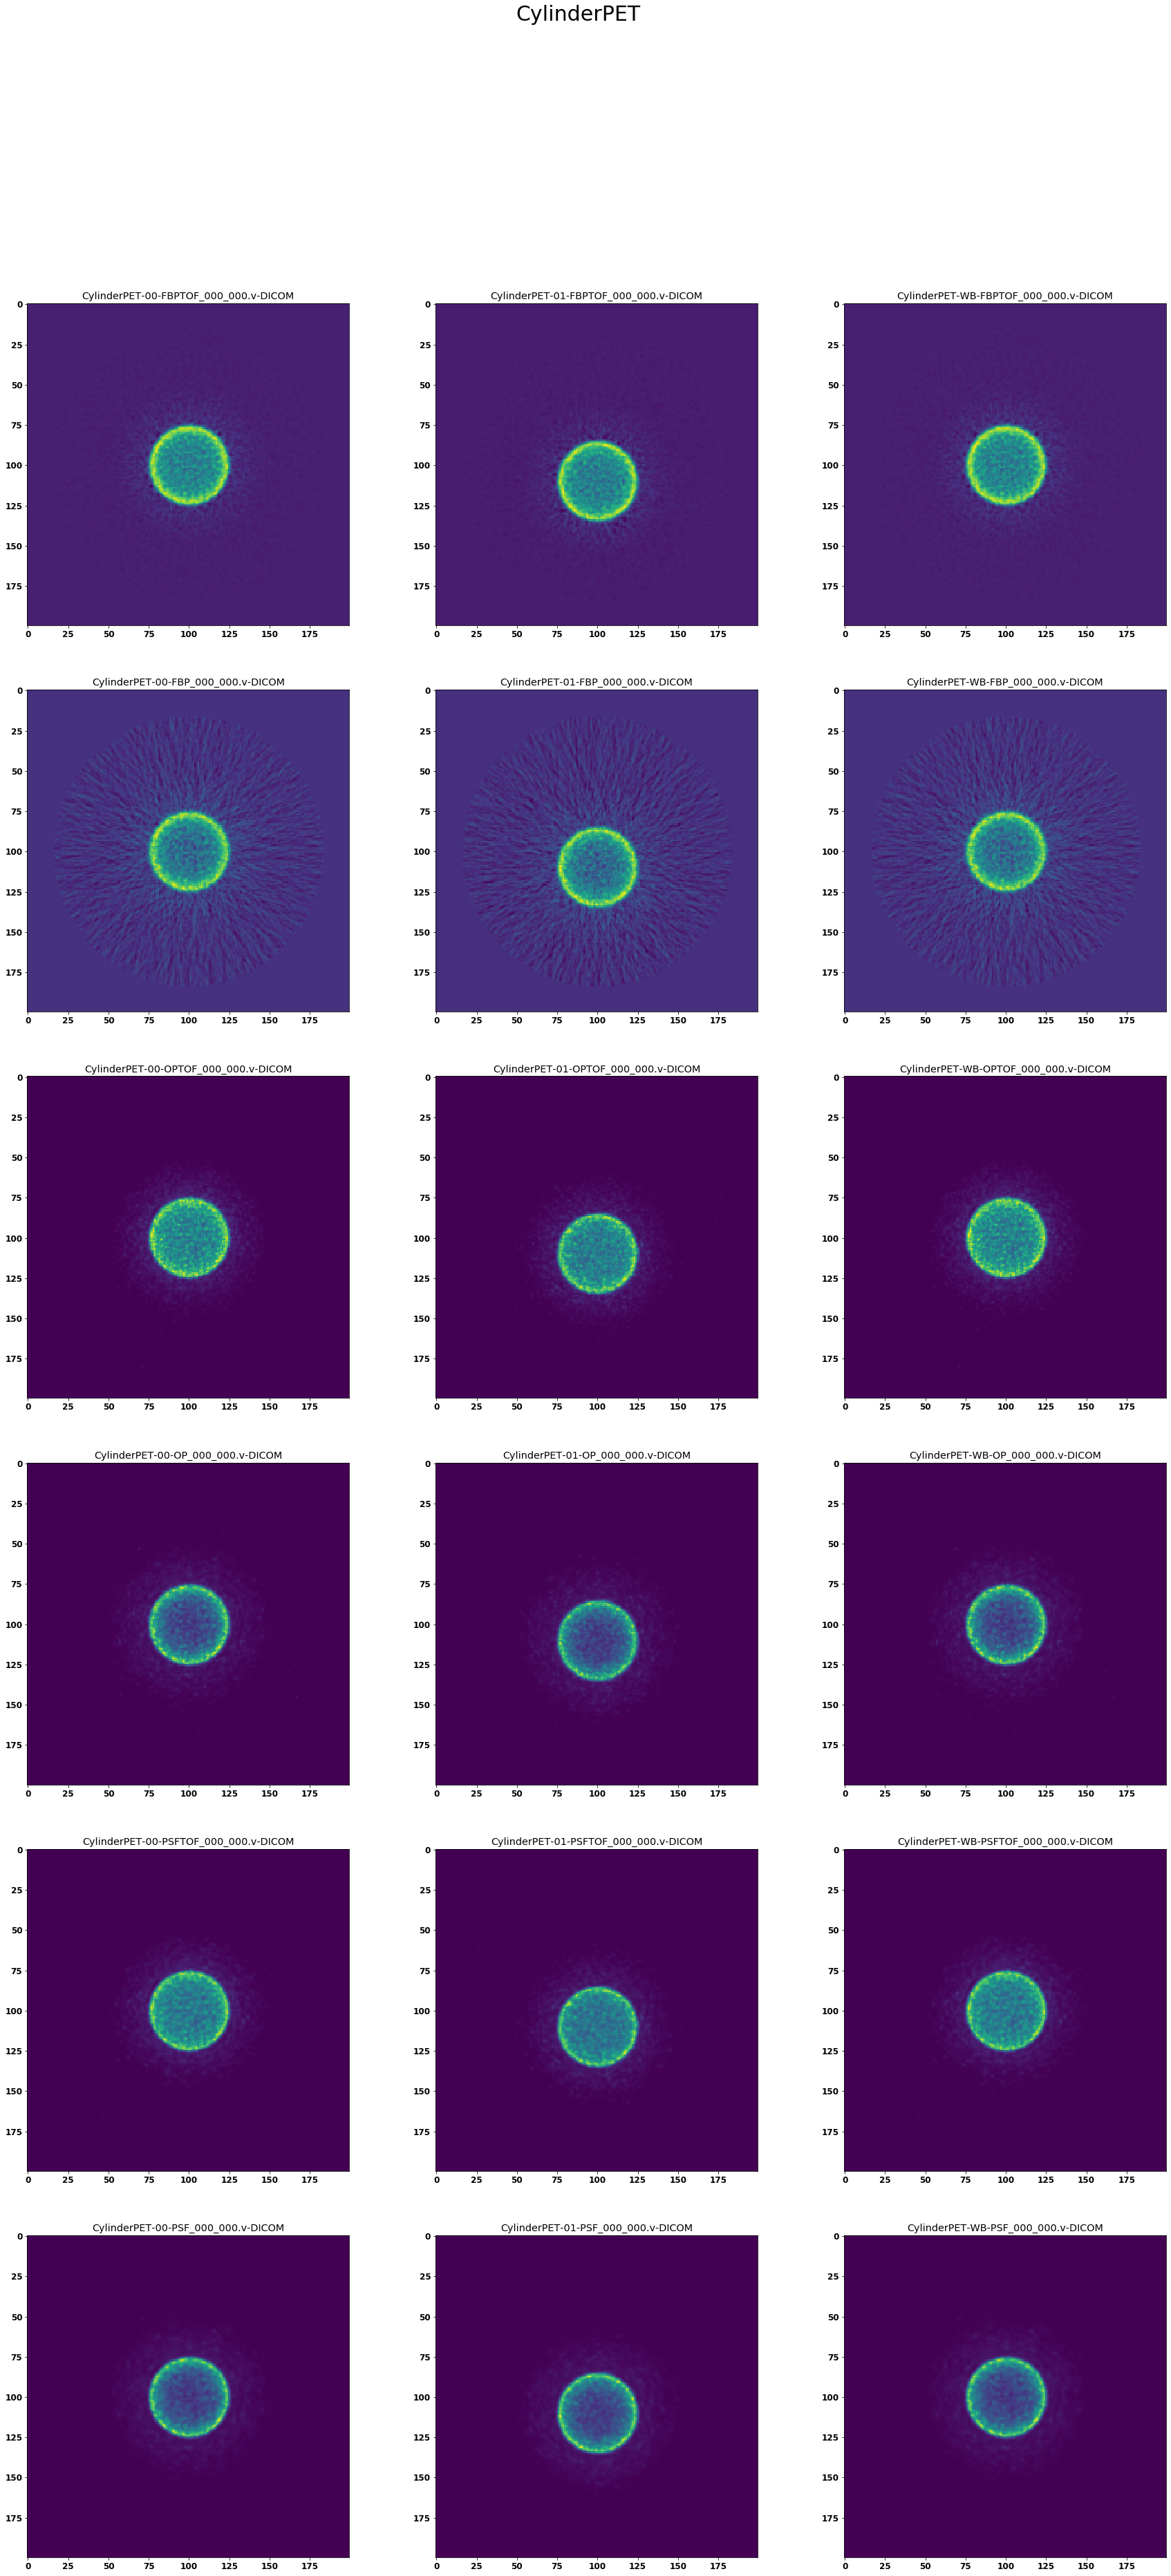

In [85]:
# plot them all
cols = len(img_titles)
rows = len(img_titles[0])
scale = 10
plt.figure(figsize=(scale*cols,scale*rows))
plt.suptitle('CylinderPET', fontsize=30)

for c in range(0, cols):
    for r in range(0, rows):
        index = 1+r*cols+c
        print(index)
        ax = plt.subplot(rows, cols,index)
        i_title = img_titles[c][r]
        img_dir = os.path.join(top, subs[c], i_title)
        patient_dicom = load_scan(img_dir)
        patient_pixels = get_pixels_hu(patient_dicom)
        plt.imshow(patient_pixels[slice]);
        plt.title(i_title)

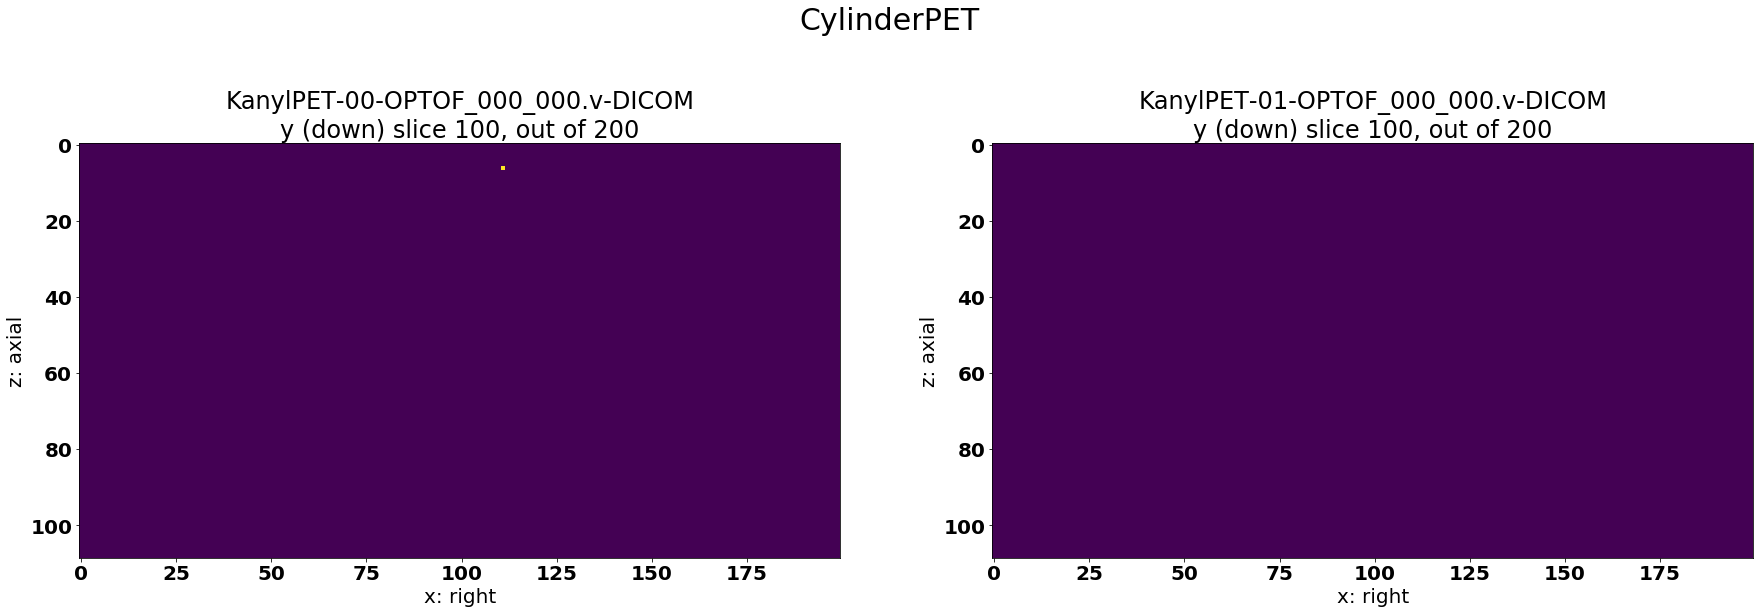

In [435]:
#plot just 1 row
plt.figure(figsize=(30,10))
plt.suptitle('CylinderPET', fontsize=30)
cols = len(img_titles)-1
row = 2
slice = 100
dim = 1
dim_order = [1]
for i in range(0,len(img_dim_titles)):
    if i != dim:
        dim_order.append(i) 

for c in range(0, cols):
        ax = plt.subplot(1, cols,c+1)
        i_title = img_titles[c][row]
        img_dir = os.path.join(top, subs[c], i_title)
        patient_dicom = load_scan(img_dir)
        patient_pixels = get_pixels_hu(patient_dicom)
        size = patient_pixels.shape
        
        plt.imshow(patient_pixels.transpose(tuple(dim_order))[slice]);
        plt.title(i_title + "\n" + "y (down) slice " + str(slice) + ", out of " + str(size[2]))
        plt.xlabel("x: right")
        plt.ylabel("z: axial")


    #original_dcm_pix = 81;
    
bef = get_pixels_hu(load_scan(os.path.join(top, subs[0], img_titles[0][2])))
wb =  get_pixels_hu(load_scan(os.path.join(top, subs[2], img_titles[2][2])))
diff = bef-wb


In [130]:
print(sum(sum(sum(abs(diff)))))


0


In [116]:
# slide through dicom images using a slide bar 
img_dir = os.path.join(top, subs[1], img_titles[1][2])
patient_dicom = load_scan(img_dir)
patient_pixels = get_pixels_hu(patient_dicom)

def dicom_animation(x):
    #figure
    img = plt.imshow(patient_pixels[:,:,x])
    return x

interact(dicom_animation, x=(0, patient_pixels.shape[1]-1));
#plt.set_cmap('gray')
#colorbar

plt.show();

interactive(children=(IntSlider(value=99, description='x', max=199), Output()), _dom_classes=('widget-interact…

a\b\c


In [5]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is air.
    # Improvement: Pick multiple background labels from around the patient
    # More resistant to “trays” on which the patient lays
    # cutting the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 

    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

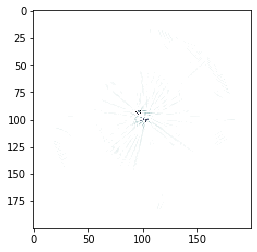

In [6]:
# get masks 
segmented_lungs = segment_lung_mask(patient_pixels,    
                  fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(patient_pixels,     
                       fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(seg_lung_pixels[slice], cmap=plt.cm.bone);

In [48]:
class GK:
    def __init__(self, n_clusters=4, max_iter=100, m=2, error=1e-6):
        super().__init__()
        self.u, self.centers, self.f = None, None, None
        self.clusters_count = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        
def fit(self, z):
        N = z.shape[0]
        C = self.clusters_count
        centers = []
        
        
        u = np.random.dirichlet(np.ones(N), size=C)
        
        
        iteration = 0
        while iteration < self.max_iter:
            u2 = u.copy()
            centers = self.next_centers(z, u)
            f = self._covariance(z, centers, u)
            dist = self._distance(z, centers, f)
            u = self.next_u(dist)
            iteration += 1
            # Stopping rule
            if norm(u - u2) < self.error:
                break
        self.f = f
        self.u = u
        self.centers = centers
        return centers
    
def gk_segment(img, clusters=5, smooth=False):
    # expand dims of binary image (1 channel in z axis)
    new_img = np.expand_dims(img, axis=2)
    # reshape
    x, y, z = new_img.shape
    new_img = new_img.reshape(x * y, z)
    # segment using GK clustering
    algorithm = GK(n_clusters=clusters)
    cluster_centers = algorithm.fit(new_img)
    output = algorithm.predict(new_img)
    segments = cluster_centers[output].astype(np.int32).reshape(x, y)
    # get cluster that takes up least space (nodules / airway)
    min_label = min_label_volume(segments)
    segments[np.where(segments != min_label)] = 0
    segments[np.where(segments == min_label)] = 1
    return segments

In [81]:
# cluster slices (range)
dist = 2
selected_slices = seg_lung_pixels[slice-dist:slice+(dist+1)]
gk_clustered_imgs = np.array([gk_segment(x) for x in selected_slices])
# display middle slice 
plt.imshow(gk_clustered_imgs[2], cmap=plt.cm.bone)

AttributeError: 'GK' object has no attribute 'fit'

In [7]:
def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = art3d.Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

In [423]:
#all different reconstructions

top = r"C:\Users\petct\Desktop\KanylPET-Converted"

for root, dirs, files in os.walk(top):
    #print(root)
    subs = dirs
    #print(dirs)
    break

#print(subs)
subs = [subs[0],subs[1], subs[4]]
#print(subs)
#print("----------")
img_titles = []
for k in subs:
    #print(k)
    for root, dirs, files in os.walk(os.path.join(top,k)):
        img_titles.append(dirs)
        #print(len(dirs))
        #print(dirs)
        break

#print("----")
#print(img_titles)
#print("images titles shape:", len(img_titles), len(img_titles[0]))
#print(np.array(img_titles).size)

1
4
7
10
13
16
2
5
8
11
14
17
3
6
9
12
15
18


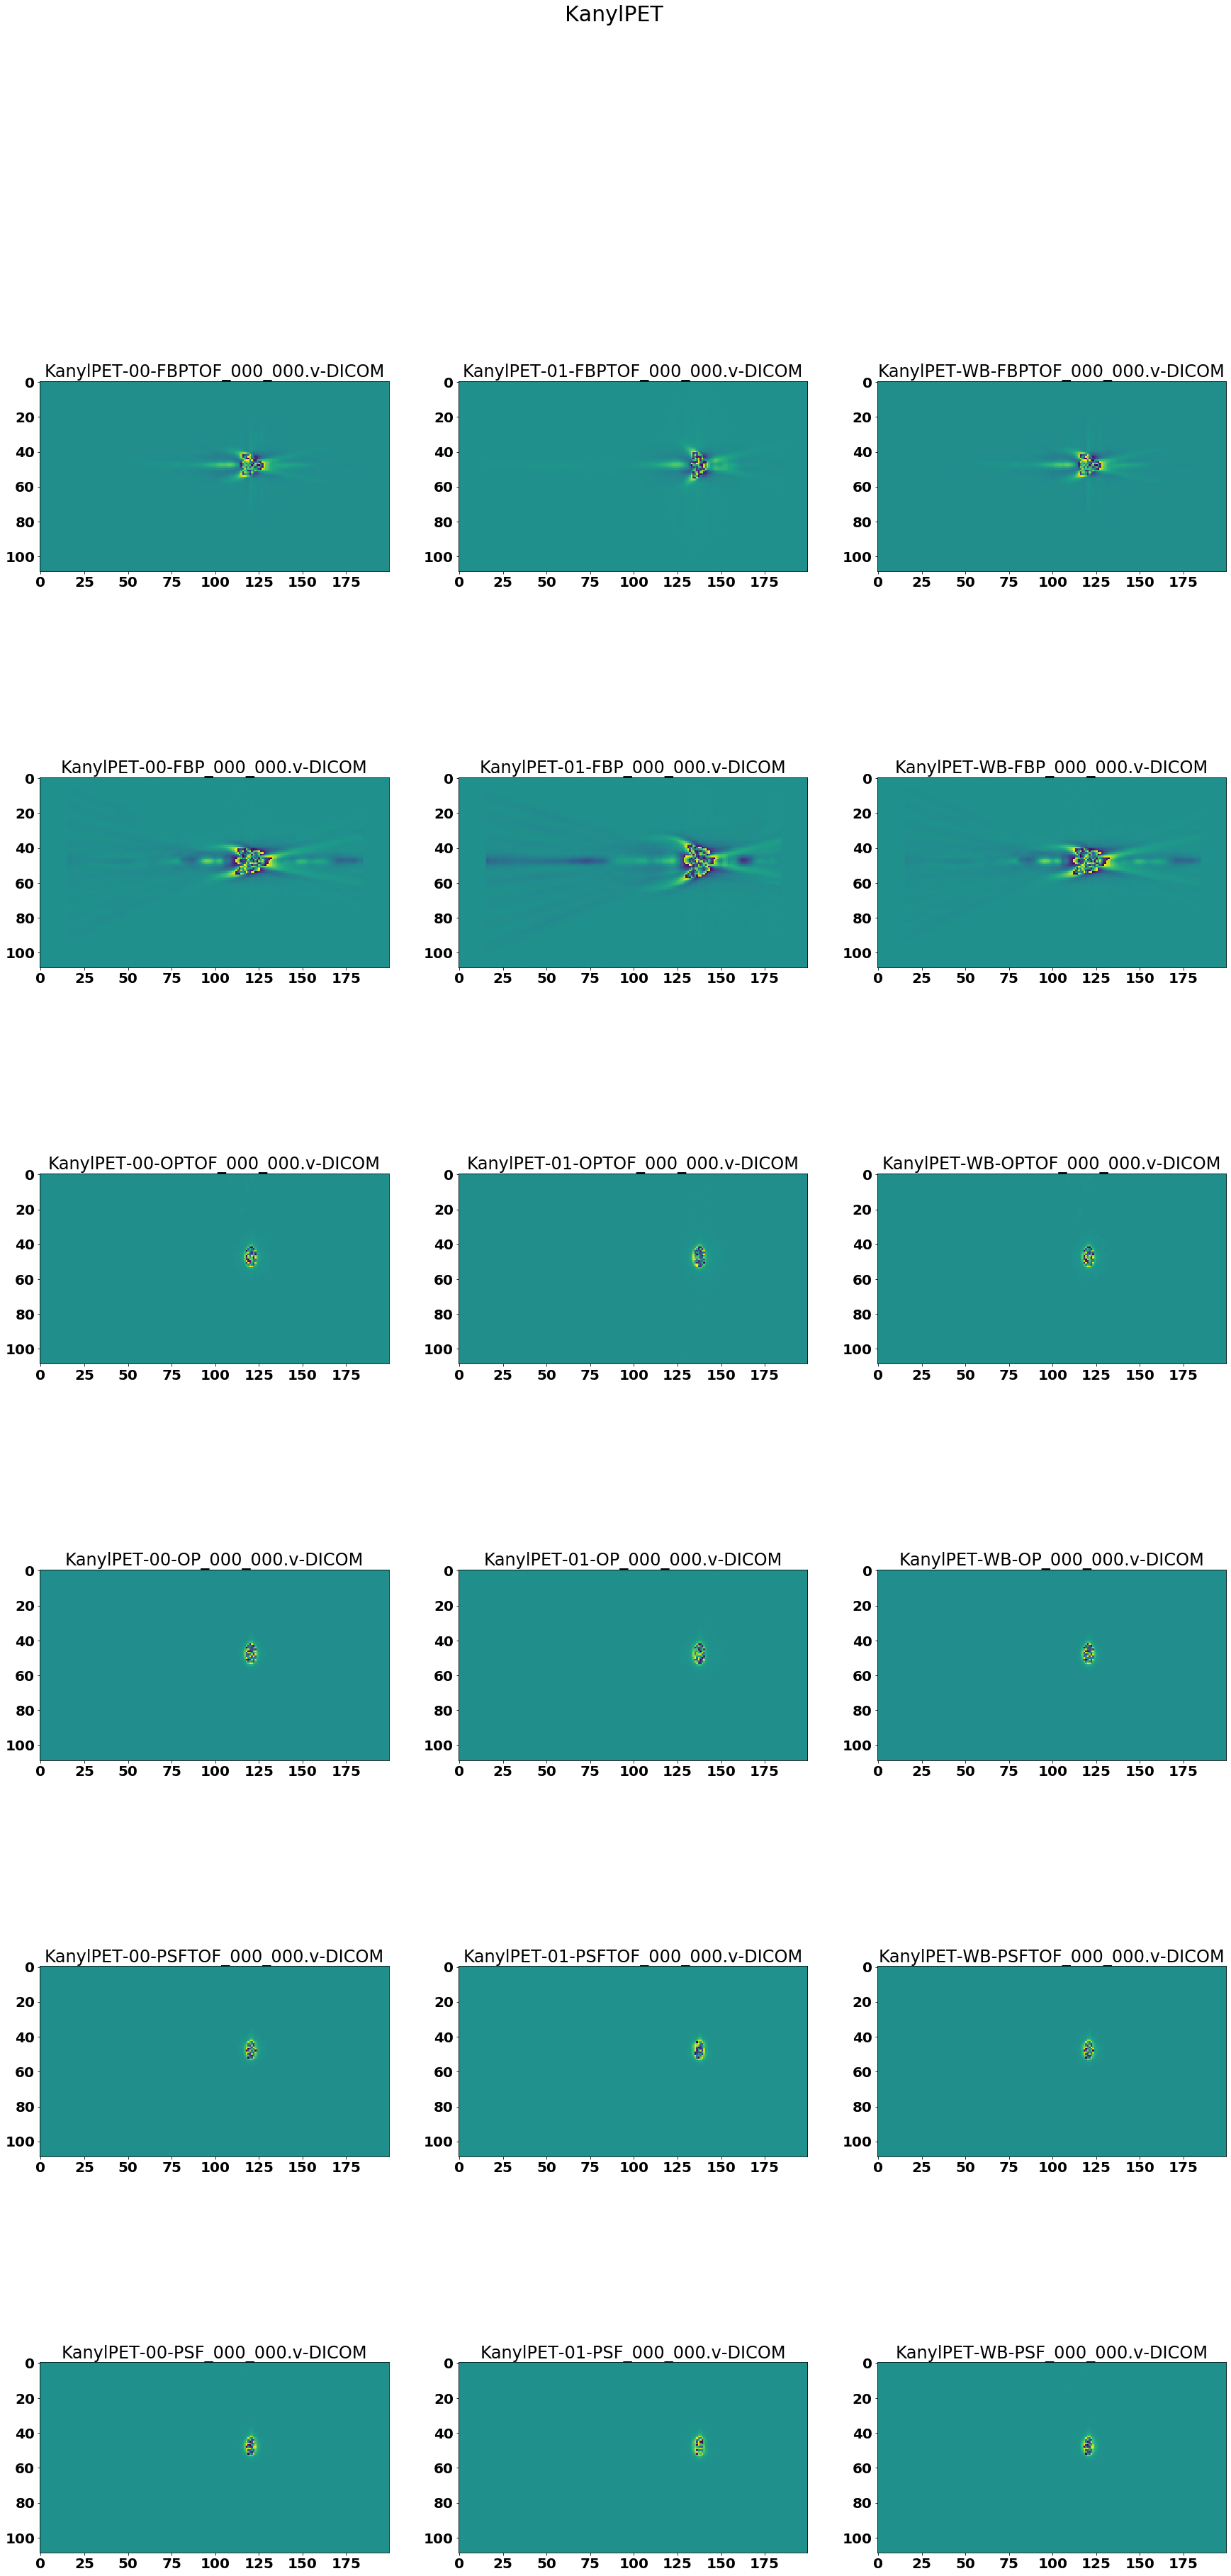

In [424]:
# plot them all
cols = len(img_titles)
rows = len(img_titles[0])
scale = 10
plt.figure(figsize=(scale*cols,scale*rows))
plt.suptitle('KanylPET', fontsize=30)
slice = 100
for c in range(0, cols):
    for r in range(0, rows):
        index = 1+r*cols+c
        print(index)
        ax = plt.subplot(rows, cols,index)
        i_title = img_titles[c][r]
        img_dir = os.path.join(top, subs[c], i_title)
        patient_dicom = load_scan(img_dir)
        patient_pixels = get_pixels_hu(patient_dicom)
        plt.imshow(patient_pixels[:,:,slice]);
        plt.title(i_title)


counts in slice 2532
Kanyl center [118.83333333  97.16666667]
counts in slice 730
Kanyl center [139.   93.5]
counts in slice 2532
Kanyl center [118.83333333  97.16666667]


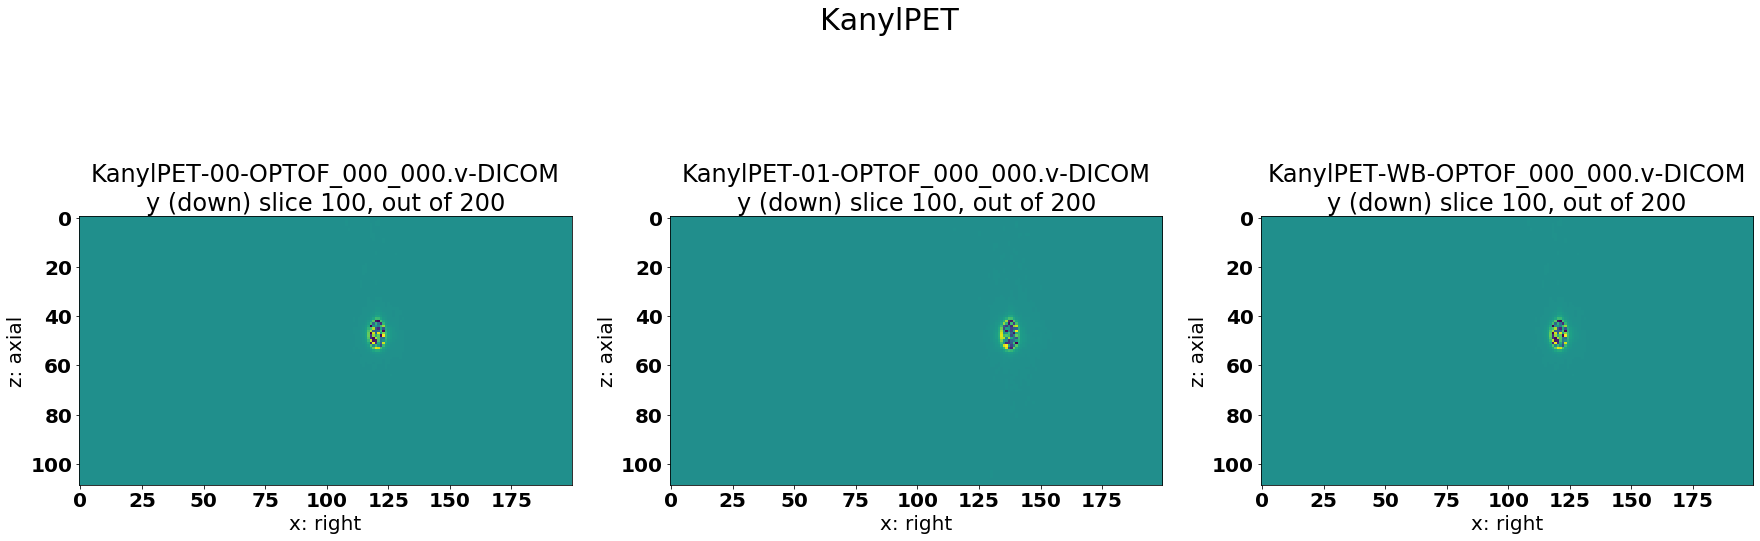

In [426]:
#plot just 1 row
plt.figure(figsize=(30,10))
plt.suptitle('KanylPET', fontsize=30)
cols = len(img_titles)
row = 2
slice = 100
for c in range(0, cols):
        ax = plt.subplot(1, cols,c+1)
        i_title = img_titles[c][row]
        img_dir = os.path.join(top, subs[c], i_title)
        patient_dicom = load_scan(img_dir)
        patient_pixels = get_pixels_hu(patient_dicom)
        size = patient_pixels.shape
        center = np.zeros(2)
        #order zxy
        counts = 0
        for x in range(0, size[1]):
            for y in range(0, size[2]):
                counts += patient_pixels[0,x,y]
                center[0] += patient_pixels[0,x,y]*x
                center[1] += patient_pixels[0,x,y]*y
        print("counts in slice", counts)
        center = center/counts
        print("Kanyl center", center)
        
        plt.imshow(patient_pixels[:,:,slice]);
        plt.title(i_title + "\n" + "y (down) slice " + str(slice) + ", out of " + str(size[2]))
        plt.xlabel("x: right")
        plt.ylabel("z: axial")


    #original_dcm_pix = 81;
    
bef = get_pixels_hu(load_scan(os.path.join(top, subs[0], img_titles[0][2])))
wb =  get_pixels_hu(load_scan(os.path.join(top, subs[2], img_titles[2][2])))
diff = bef-wb


In [427]:

x = []
y = []
hori = []
slice_counts = []

for z in range(0,patient_pixels.shape[0]):
    hori.append(z)
    position,counts = CenterOfMassRecursion(patient_pixels[z])
    x.append(position[1]/counts)
    y.append(position[0]/counts)
    slice_counts.append(counts)

print("data processed")

<ipython-input-427-d3f1e0d0a548>:9: RuntimeWarning:

invalid value encountered in long_scalars

<ipython-input-427-d3f1e0d0a548>:10: RuntimeWarning:

invalid value encountered in long_scalars



data processed


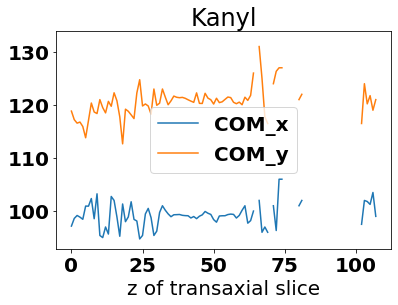

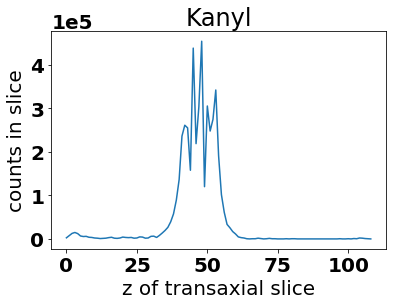

In [428]:

plt.plot(hori,x,hori,y)
plt.xlabel("z of transaxial slice")
plt.legend(["COM_x", "COM_y"])
plt.title("Kanyl")
plt.show()

plt.plot(hori, slice_counts)
plt.xlabel("z of transaxial slice")
plt.ylabel("counts in slice")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0)) 
plt.title("Kanyl")
plt.show()
    

In [58]:
#numpy meshgrid
X = np.meshgrid(np.arange(0,5,1), np.arange(0,5,1))
for x in X:
    print(x,"\n")

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]] 

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]] 



In [98]:
#numpy matrix multiplication

A = [[3,5,7], [2,11,13]]
B = [0,1,2]
base = (1,1)

B = np.reshape(B, (1,len(B)))
C = [0,1]
C = np.reshape(C, (len(C),1))
print("A\n",A)
print("B\n",B) 
print("C\n",C)

AB = np.multiply(A,B)
AC = np.multiply(A,C)

print("AB\n",AB)
print("AC\n",AC)

print("AB sum=", np.sum(AB))
print("AC sum=", np.sum(AC))
print(np.arange(3.0))
A = np.array(A)
COMpos, counts = CenterOfMassMultiplication(A)
print(COMpos, counts)
A = np.array([A,A])
COMpos, counts = CenterOfMassMultiplication(A)
print(COMpos, counts)

A
 [[3, 5, 7], [2, 11, 13]]
B
 [[0 1 2]]
C
 [[0]
 [1]]
AB
 [[ 0  5 14]
 [ 0 11 26]]
AC
 [[ 0  0  0]
 [ 2 11 13]]
AB sum= 56
AC sum= 26
[0. 1. 2.]
temp [0 1]
temp_shape (2, 1)
temp [0 1 2]
temp_shape (1, 3)
[26, 56] 41
temp [0 1]
temp_shape (2, 1, 1)
temp [0 1]
temp_shape (1, 2, 1)
temp [0 1 2]
temp_shape (1, 1, 3)
[41, 52, 112] 82
